<a href="https://colab.research.google.com/github/yuya1951/deeplarning/blob/main/ssd_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jan  2 05:31:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [ ]:
!git clone https://github.com/ryomaouchi/SSD_airplane_sorabtake.git
#自分のデータを使用する場合util内のdataloaderのコードをカスタム

Cloning into 'SSD_airplane_sorabtake'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 76 (delta 26), reused 52 (delta 11), pack-reused 0
Unpacking objects: 100% (76/76), done.


In [ ]:
!git clone https://github.com/hituji1012/od_test.git

Cloning into 'od_test'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 301 (delta 139), reused 291 (delta 135), pack-reused 0
Receiving objects: 100% (301/301), 23.20 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (282/282), done.


In [ ]:
!pip install torch==1.0.1
!pip install torchvision==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.0.1 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.1 MB/s 
Reason for being yanked: So that users won't accidentally install this when using python 3.11
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fas

In [ ]:
#必要なライブラリをインストール

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import time
import pandas as pd
import urllib.request
import zipfile
import tarfile
import cv2
import random
import xml.etree.ElementTree as ET
from math import sqrt
from glob import glob
from itertools import product

import torch
import torch.utils.data as data
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Function
from utils.augmentations import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans
from utils.dataloader import DogDataset, DataTransform, xml_to_list, od_collate_fn, get_color_mean

In [ ]:
#乱数のシードを設定
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
# Training画像とそのアノテーション、またValidation画像とそのアノテーションをそれぞれリストにする。

train_image_dir = './dog_voc/train/images/'
train_img_paths = glob(os.path.join(train_image_dir, '*.jpg'))

val_image_dir = './dog_voc/val/images/'
val_img_paths = glob(os.path.join(val_image_dir, '*.jpg'))

train_label_paths = [train_img_paths[i].replace('jpg', 'xml',1).replace('images','labels',1) for i in range(len(train_img_paths))]
val_label_paths = [val_img_paths[i].replace('jpg', 'xml',1).replace('images','labels',1) for i in range(len(val_img_paths))]

my_classes = ["dog"]

In [ ]:
#色情報の規格化のためにチャンネルごとの平均値を計算
color_mean = get_color_mean(train_img_paths)
print(color_mean)

(95.59832644490783, 110.37721204291275, 118.40671102130399)


In [ ]:
input_size = 300 #入力画像は300×300にリサイズする。

train_dataset = DogDataset(train_img_paths, train_label_paths, phase = 'train',
                                transform = DataTransform(input_size, color_mean),
                                transform_anno = xml_to_list(my_classes)
                                )

val_dataset = DogDataset(val_img_paths, val_label_paths, phase = 'val',
                                transform = DataTransform(input_size, color_mean),
                                transform_anno = xml_to_list(my_classes)
                                )

In [ ]:
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True, collate_fn = od_collate_fn
)

val_dataloader = data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = True, collate_fn = od_collate_fn
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [ ]:
# ディレクトリ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# 学習済みのSSD用のVGGのパラメータをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch

#手動でダウンロード
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth")

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [ ]:
from utils.ssd_model import SSD

ssd_cfg = {
    'num_classes': 2, # 背景を含む
    'input_size': 300,
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300], # DBoxの大きさ (なぜ)
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

net = SSD(phase='train', cfg = ssd_cfg)

vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias,0.0)

net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("使用Device:", device)

In [ ]:
from utils.loss import MultiBoxLoss

criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos = 3, device=device)

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optim.SGD(net.parameters(), lr=1e-3,momentum=0.9, weight_decay = 5e-4)

In [ ]:
def train_model(net,dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用Device:", device)

    net.to(device)

    #torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.benchmark = False

    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []

    #学習開始
    for epoch in range(num_epochs+1):
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                print(' (train) ')

            else:
                if ((epoch+1) % 10 == 0):
                    net.eval()
                    print('----------')
                    print(' (val) ')

                else:
                    continue

            for images, targets in dataloaders_dict[phase]:
                images = images.to(device)
                targets = [ann.to(device)
                            for ann in targets]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(images)

                    #損失関数は、バウンディングボックスの位置の予測に関するもの(=loss_l)と分類予測に関するもの(=loss_c)の和になる。
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    if phase == 'train':
                        loss.backward()

                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value = 2.0
                            )

                        optimizer.step()

                        if (iteration % 2 ==0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter:{:.4f} sec.'.format(
                            iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    else:
                        epoch_val_loss += loss.item()


        t_epoch_finish = time.time()
        print('------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} || Epoch_VAL_Loss:{:.4f}'.format(
        epoch+1, epoch_train_loss, epoch_val_loss))

        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        #10エポックごとに重みを保存する。
        if ((epoch+1)%10 ==0):
            torch.save(net.state_dict(),'weights/SSD300_'+str(epoch+1)+'.pth')

In [ ]:
num_epochs = 300

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

使用Device: cuda:0
------------
Epoch 1/300
------------
 (train) 


/content/drive/MyDrive/utils/augmentations.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


イテレーション 2 || Loss: 1507.6265 || 10iter:54.6941 sec.
イテレーション 4 || Loss: 77.7401 || 10iter:42.3904 sec.
イテレーション 6 || Loss: 71.8049 || 10iter:42.0766 sec.
イテレーション 8 || Loss: 10.2069 || 10iter:41.5165 sec.
イテレーション 10 || Loss: 5.7139 || 10iter:41.9632 sec.
イテレーション 12 || Loss: 5.5342 || 10iter:42.1247 sec.
------------
epoch 1 || Epoch_TRAIN_Loss:1818.7540 || Epoch_VAL_Loss:0.0000
timer: 287.4490 sec.
------------
Epoch 2/300
------------
 (train) 
イテレーション 14 || Loss: 5.5901 || 10iter:1.1118 sec.
イテレーション 16 || Loss: 5.5464 || 10iter:2.8481 sec.
イテレーション 18 || Loss: 5.4432 || 10iter:2.9075 sec.
イテレーション 20 || Loss: 5.2851 || 10iter:2.8637 sec.
イテレーション 22 || Loss: 5.4939 || 10iter:2.6973 sec.
イテレーション 24 || Loss: 5.3351 || 10iter:2.8505 sec.
イテレーション 26 || Loss: 5.1740 || 10iter:2.7280 sec.
------------
epoch 2 || Epoch_TRAIN_Loss:70.1718 || Epoch_VAL_Loss:0.0000
timer: 21.8550 sec.
------------
Epoch 3/300
------------
 (train) 
イテレーション 28 || Loss: 5.2250 || 10iter:2.7108 sec.
イテレーション 30 || Loss:

In [ ]:
from utils.ssd_model import SSD

my_classes = ["dog"]


ssd_cfg = {
    'num_classes': 2, # 背景を含む
    'input_size': 300,
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300], # DBoxの大きさ (なぜ)
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

net = SSD(phase='inference', cfg = ssd_cfg)

net_weights = torch.load('./weights/weight_dog/SSD300_300.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)

<All keys matched successfully>

In [ ]:
test_image_dir = './dog_test/'
test_img_paths = glob(os.path.join(test_image_dir, '*.jpg'))

/content/drive/My Drive/utils/ssd_model.py:574: UserWarning: An output with one or more elements was resized since it had shape [66], which does not match the required output shape [13]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  torch.index_select(x1, 0, idx, out=tmp_x1)
/content/drive/My Drive/utils/ssd_model.py:575: UserWarning: An output with one or more elements was resized since it had shape [66], which does not match the required output shape [13]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  tor

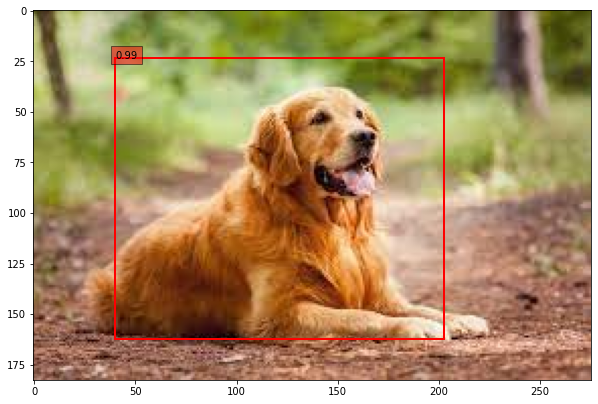

In [ ]:
from utils.ssd_predict_show import SSDPredictShow

img_file_path = test_img_paths[1]
img_file_path = "./dog_test/24.jpg"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)

12/14 検出　Accuracy 36/40⇒0.9

In [ ]:
from utils.ssd_predict_show import SSDPredictShow

img_file_path = test_img_paths[1]
img_file_path = "./test_pets/american_bulldog127.jpg"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)

In [ ]:
from utils.ssd_predict_show import SSDPredictShow

img_file_path = test_img_paths[1]
img_file_path = "./test_pets/american_pit_bull_terrier127.jpg"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)

In [ ]:
from utils.ssd_predict_show import SSDPredictShow

img_file_path = test_img_paths[1]
img_file_path = "./test_pets/basset_hound127.jpg"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)

In [ ]:
from utils.ssd_predict_show import SSDPredictShow

img_file_path = test_img_paths[1]
img_file_path = "./test_pets/beagle127.jpg"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)